<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task3(Ultra_Pro)_%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ultra Pro**

**1. Импорт библиотек.**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import math
import os
from google.colab import drive

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2. Загрузка базы фото машин.**

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/middle_fmr.zip" -d /content/cars #Указываем путь к базе в Google Drive

In [ ]:
train_path = '/content/cars' #Папка с папками картинок, рассортированных по категориям
batch_size = 10 #Размер выборки
img_width = 288 #Ширина изображения
img_height = 162 #Высота изображения

In [ ]:
#Генератор изображений
datagen = ImageDataGenerator(
    #rescale=1. / 255, #Значения цвета меняем на дробные показания
    rotation_range=10, #Поворачиваем изображения при генерации выборки
    width_shift_range=0.1, #Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1, #Зумируем изображения при генерации выборки
    horizontal_flip=True, #Включаем отзеркаливание изображений
    fill_mode='nearest', #Заполнение пикселей вне границ ввода
    validation_split=0.2 #Указываем разделение изображений на обучающую и тестовую выборку
)

In [ ]:
# обучающая выборка
train_generator = datagen.flow_from_directory(
    train_path, #Путь ко всей выборке выборке
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, #Перемешивание выборки
    subset='training' # устанавливаем как набор для обучения
)

# проверочная выборка
validation_generator = datagen.flow_from_directory(
    train_path, #Путь ко всей выборке выборке
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, #Перемешивание выборки
    subset='validation' # устанавливаем как валидационный набор
)

Found 2743 images belonging to 3 classes.
Found 684 images belonging to 3 classes.


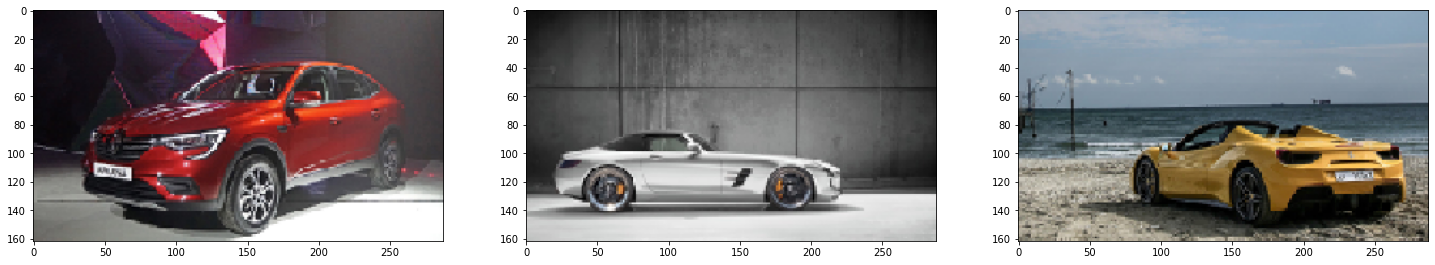

In [ ]:
#Выводим для примера картинки по каждому классу
fig, axs=plt.subplots(1,3,figsize=(25,5))
for i in range(3):
  car_path = train_path + '/' + os.listdir(train_path)[i] + '/'#Формируем путь к выборке
  img_path = car_path + random.choice(os.listdir(car_path)) #Выбираем случайное фото для отображения
  axs[i].imshow(image.load_img(img_path, target_size=(img_height, img_width))) #Отображение фотографии
plt.show()

**4. Создание и обучение сети.**

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(img_width, img_height, 3)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.3))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(2000, activation='elu'))
model.add(Dense(4000, activation='elu'))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 288, 162, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 288, 162, 256)     7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 288, 162, 256)     590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 54, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 54, 512)       1180160   
_________________________________________________________________
dropout (Dropout)            (None, 96, 54, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 54, 512)       2

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=60,
    verbose=1
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
274/274 [==============================] - 184s 524ms/step - loss: 1.0441 - accuracy: 0.4892 - val_loss: 0.9860 - val_accuracy: 0.5279
Epoch 2/60
274/274 [==============================] - 139s 506ms/step - loss: 0.8975 - accuracy: 0.5770 - val_loss: 1.0205 - val_accuracy: 0.4500
Epoch 3/60
274/274 [==============================] - 139s 506ms/step - loss: 0.8429 - accuracy: 0.6103 - val_loss: 0.9393 - val_accuracy: 0.5574
Epoch 4/60
274/274 [==============================] - 138s 505ms/step - loss: 0.8202 - accuracy: 0.6184 - val_loss: 0.8780 - val_accuracy: 0.5765
Epoch 5/60
274/274 [==============================] - 139s 506ms/step - loss: 0.8032 - accuracy: 0.6198 - val_loss: 0.8790 - val_accuracy: 0.5897
Epoch 6/60
274/274 [==============================] - 139s 508ms/step - loss: 0.7767 - accuracy: 0.6553 - val_loss: 0.8557 - val_accuracy: 0.6059
Epoch 7/60
274/274 [==============================] - 139s 508ms/step - loss: 0.7567 - accuracy: 0.6608 - val_loss: 0.8978 -

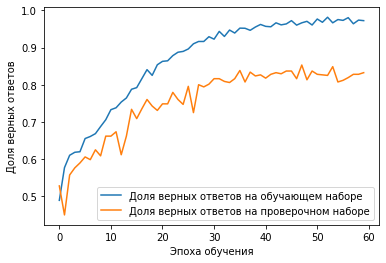

In [ ]:
#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=50,
    verbose=1
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
274/274 [==============================] - 139s 506ms/step - loss: 0.0310 - accuracy: 0.9923 - val_loss: 0.5720 - val_accuracy: 0.8603
Epoch 2/50
274/274 [==============================] - 139s 505ms/step - loss: 0.0255 - accuracy: 0.9923 - val_loss: 0.5795 - val_accuracy: 0.8559
Epoch 3/50
274/274 [==============================] - 139s 506ms/step - loss: 0.0206 - accuracy: 0.9938 - val_loss: 0.5430 - val_accuracy: 0.8647
Epoch 4/50
274/274 [==============================] - 139s 506ms/step - loss: 0.0195 - accuracy: 0.9930 - val_loss: 0.6430 - val_accuracy: 0.8426
Epoch 5/50
274/274 [==============================] - 139s 505ms/step - loss: 0.0091 - accuracy: 0.9967 - val_loss: 0.5782 - val_accuracy: 0.8838
Epoch 6/50
274/274 [==============================] - 139s 506ms/step - loss: 0.0165 - accuracy: 0.9960 - val_loss: 0.5964 - val_accuracy: 0.8529
Epoch 7/50
274/274 [==============================] - 139s 506ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.6187 -

In [ ]:
#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()